In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
        # # Compute the L2 loss for depth (between predicted and ground truth depth)
        # depth_pred = pred1['pts3d'][..., 2]  # Extract the predicted depth (z-coordinate)
        # gt_depthmap = gt1["depthmap"].to(depth_pred.device)
        # # l1 = self.criterion(depth_pred,gt_depthmap)
        # # depth_loss = torch.sqrt(torch.mean((depth_pred - gt_depthmap)**2))

        
        # epsilon = 1e-8  # To avoid log(0)
        # log_diff = torch.log(depth_pred + epsilon) - torch.log(gt_depthmap + epsilon)
        # loss = torch.sqrt(torch.mean(log_diff ** 2) - (torch.mean(log_diff) ** 2))

        # # # Compute accuracy-based loss (Threshold-based accuracy)
        # # threshold = torch.max(depth_pred / gt_depthmap, gt_depthmap / depth_pred)
        # # acc_1_25 = torch.mean((threshold < 1.25).float())  # Accuracy with threshold 1.25
        # # acc_1_25_2 = torch.mean((threshold < 1.25**2).float())  # Accuracy with threshold 1.25^2



        # # # Track individual losses for debugging or analysis
        # details = {
        #     "RMSE Loss": loss.item(),
        #     # "Accuracy < 1.25": acc_1_25.item(),
        #     # "Accuracy < 1.25^2": acc_1_25_2.item(),

... loading model from /home/user/elwakeely1/dust3r/checkpoints/dust3r_demo_1/checkpoint-last.pth
instantiating : AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), enc_embed_dim=1024, enc_depth=24, enc_num_heads=16, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, landscape_only=False)
<All keys matched successfully>


Processing sequence:   0%|          | 0/5 [00:00<?, ?img/s]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


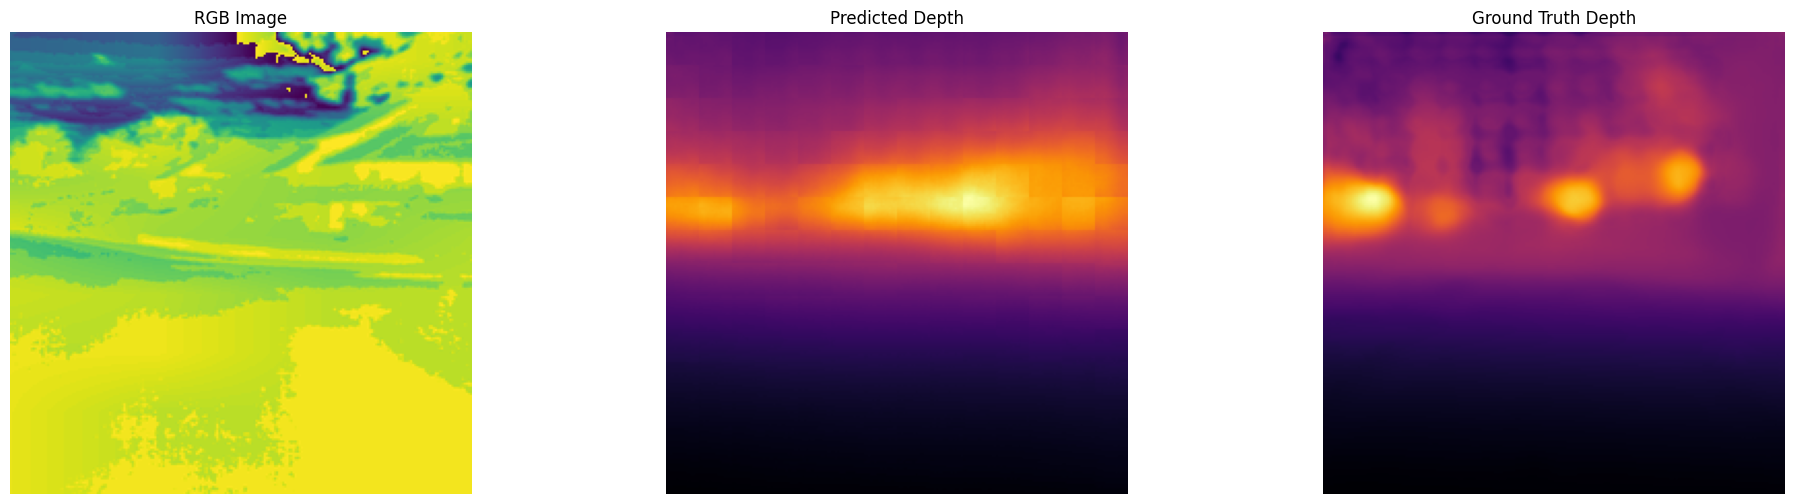

Processing sequence:  20%|██        | 1/5 [00:02<00:10,  2.60s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


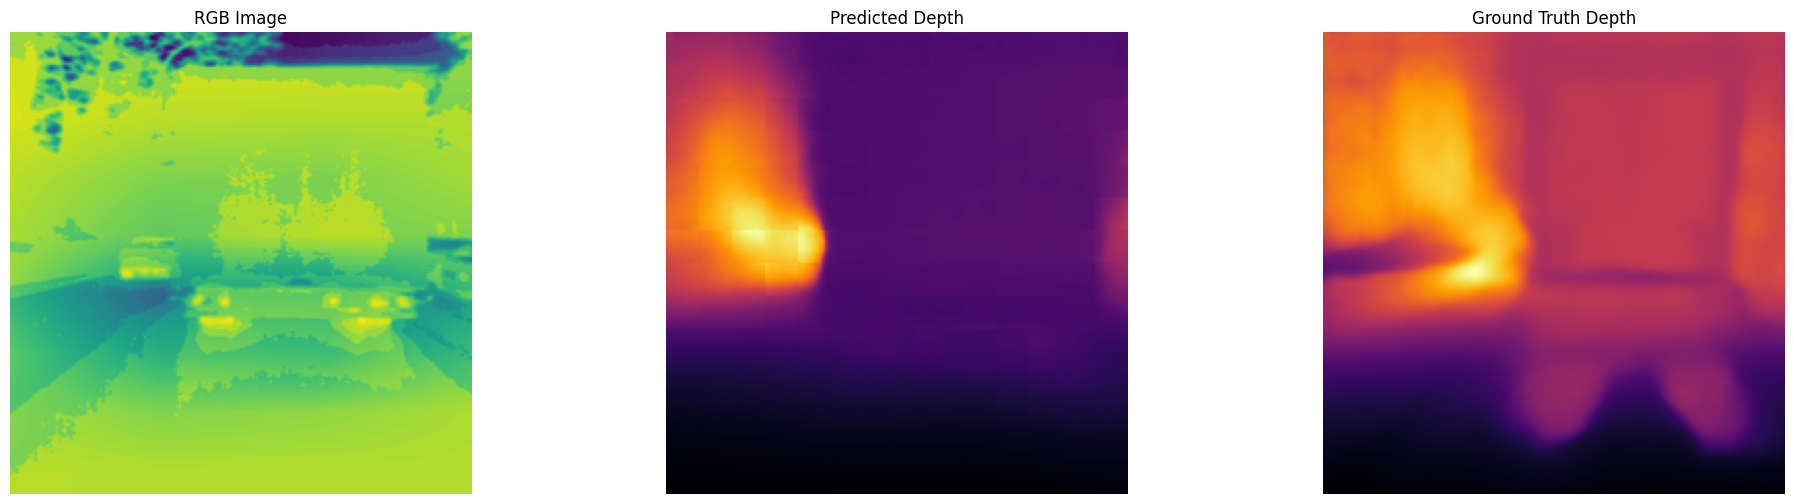

Processing sequence:  40%|████      | 2/5 [00:05<00:07,  2.54s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


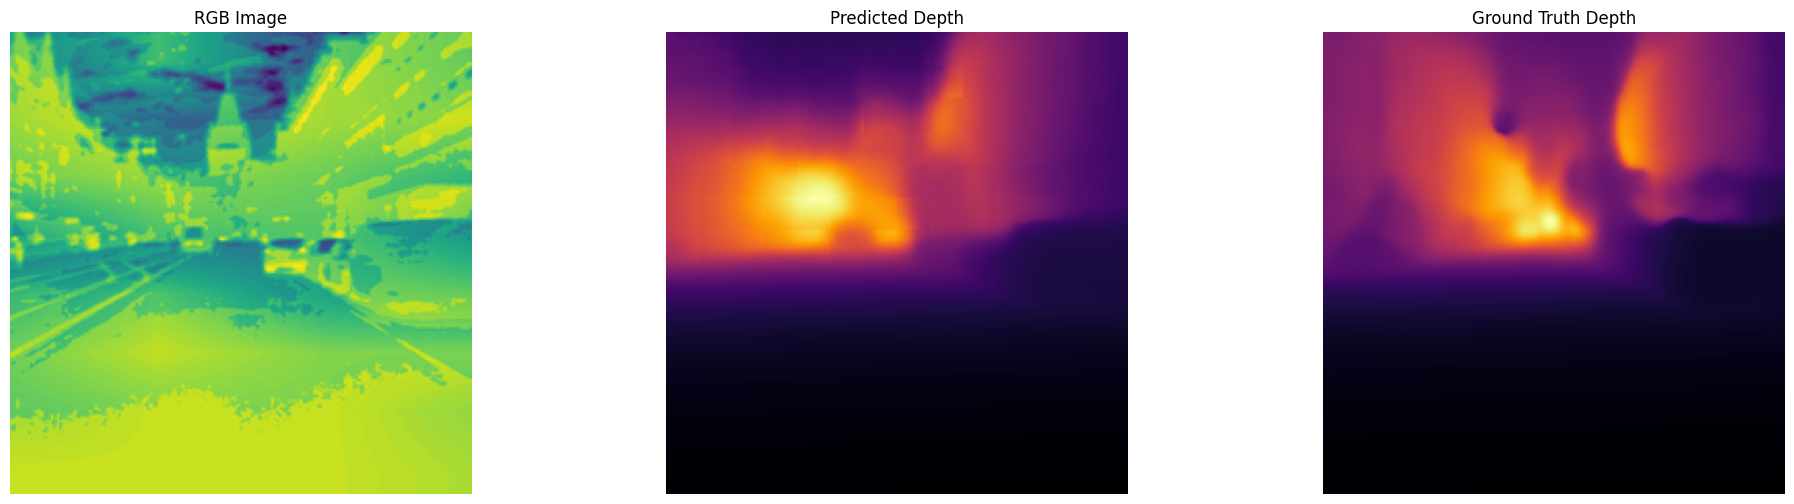

Processing sequence:  60%|██████    | 3/5 [00:07<00:05,  2.50s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


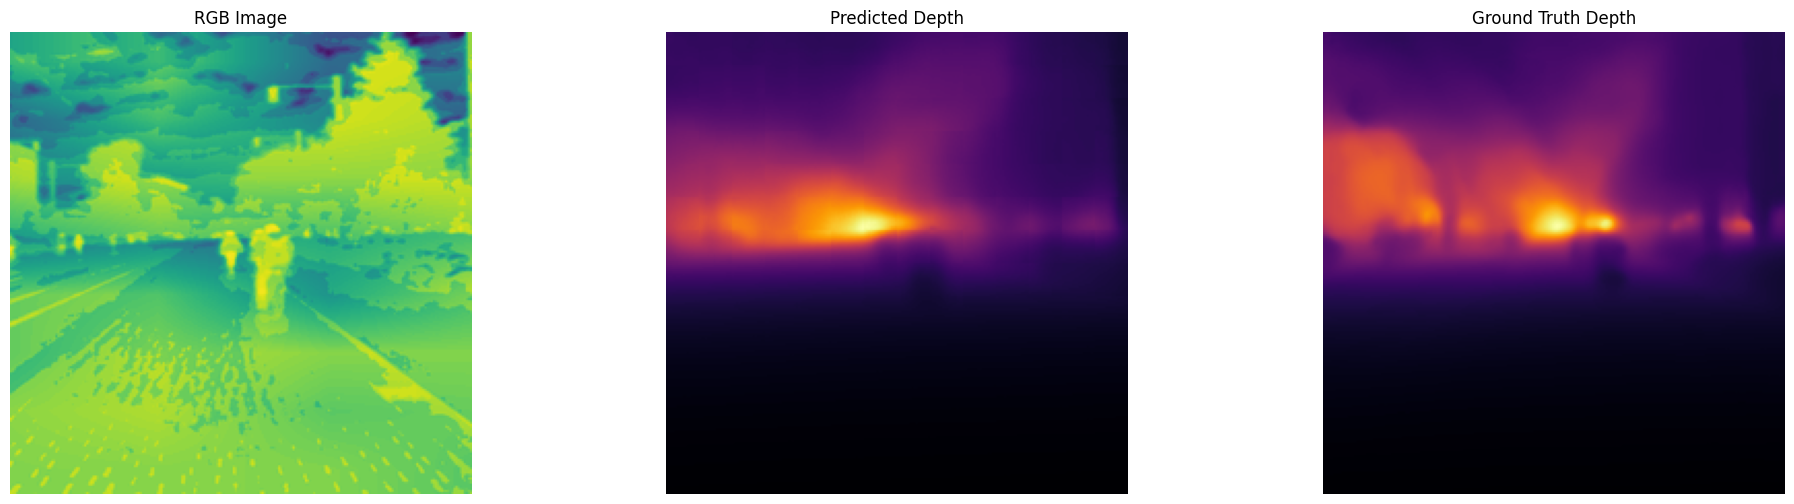

Processing sequence:  80%|████████  | 4/5 [00:10<00:02,  2.56s/img]

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


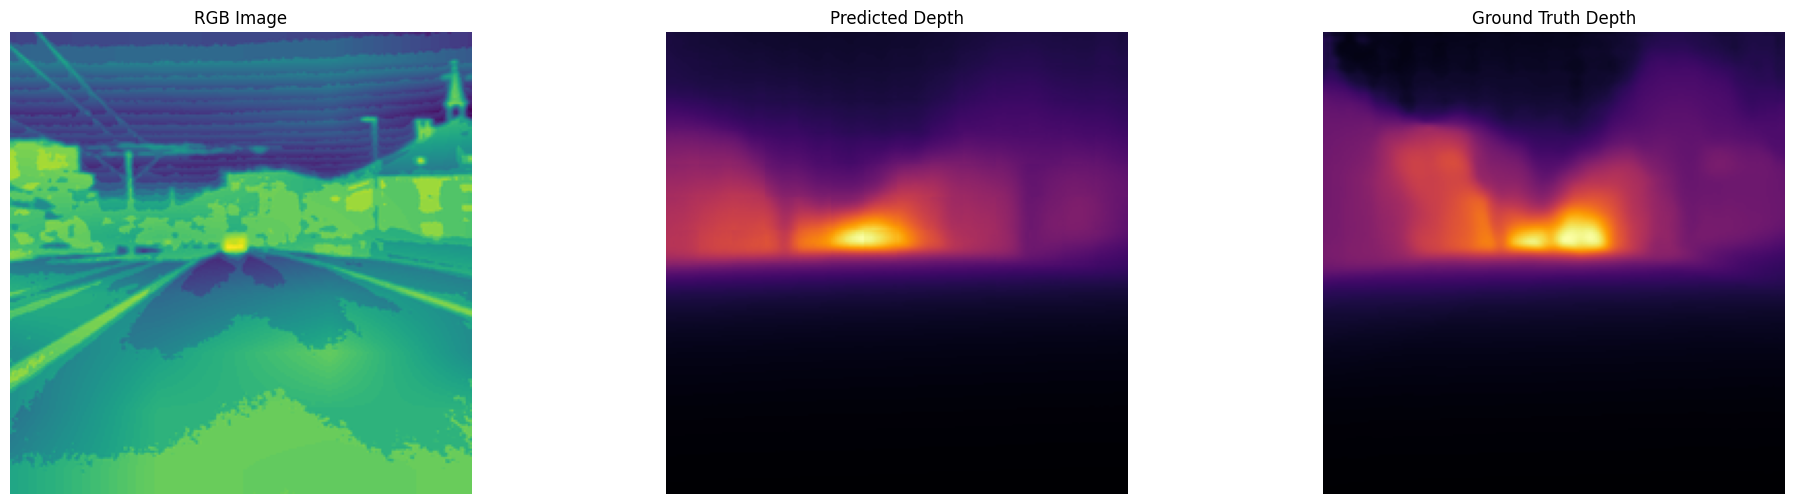

Processing sequence: 100%|██████████| 5/5 [00:12<00:00,  2.54s/img]


In [42]:
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images,load_images_test
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode
from dust3r.datasets.freiburgDataset import freiburgDataset 
import tqdm
import matplotlib.pyplot as plt
import numpy as np 


import torchvision.transforms as T
from PIL import Image
import torch

if __name__ == '__main__':
    # device = 'cuda'
    batch_size = 1
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    # model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricCroCo3DStereo.from_pretrained("/home/user/elwakeely1/dust3r/checkpoints/dust3r_demo_1/checkpoint-last.pth", strict=False)
    # model = AsymmetricCroCo3DStereo.from_pretrained(model_name)
    # load_images can take a list of images or a directory
    test_dataset =freiburgDataset(ROOT='/home/user/elwakeely1/DataParam', split='Test', resolution=224, aug_crop=16,method = 'RANSAC')

    for i in tqdm.tqdm(range(5), desc="Processing sequence", unit="img"):
        view11,view21 = test_dataset[i]
        img = view11['img']
        images = load_images_test([img,img], size=224)
        pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
        output = inference(pairs,model, None, batch_size=batch_size)

        # at this stage, you have the raw dust3r predictions
        view12, pred1 = output['view1'], output['pred1']
        view22, pred2 = output['view2'], output['pred2']
        pts3d = pred1['pts3d']
        # If shape is [B, H, W, 3], permute to [B, 3, H, W]
        if pts3d.shape[-1] == 3:
            pts3d = pts3d.permute(0, 3, 1, 2)

        # Extract the Z-coordinate (depth)
        depth_pred = pts3d[0, 2, :, :].squeeze()


        img = view11["img"]
        if isinstance(img, torch.Tensor):
            img = img.cpu().detach().numpy()
        depth_gt = view11["depthmap"]
        img = view11["img"][0]
        img = img.cpu().detach().numpy()
        # img = img.permute(1, 2, 0).cpu().detach().numpy()
        # If values are in range [0, 1], scale to [0, 255]
        if img.max() <= 1.0:
            img = (img * 255).astype('uint8')
        if depth_pred.max() <= 1.0:
            depth_pred = (depth_pred * 255).astype('uint8')
        # Create a subplot with 1 row and 3 columns
        fig, ax = plt.subplots(1, 3, figsize=(24, 6))

        # Plot the RGB image (img)
        ax[0].imshow(img)  # For RGB, no cmap needed
        ax[0].axis('off')  # Hide axes for a cleaner view
        ax[0].set_title('RGB Image')

        # Plot the predicted depth map (depth_pred) with colormap 'turbo'
        ax[1].imshow(depth_pred, cmap='inferno')  # Apply colormap for depth
        ax[1].axis('off')  # Hide axes
        ax[1].set_title('Predicted Depth')

        # Plot the ground truth depth map (depth_gt) with colormap 'turbo'
        ax[2].imshow(depth_gt, cmap='inferno')  # Apply colormap for depth
        ax[2].axis('off')  # Hide axes
        ax[2].set_title('Ground Truth Depth')

        # Show the images
        plt.show()
        
